# FSL Feat 1

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob, os
import subprocess as sp
import pandas as pd
from openpyxl import load_workbook

pd.set_option('display.max_rows', 300)
plt.rcParams["figure.figsize"] = (20,15)


---

In [2]:
study_path="/projects/niblab/experiments/bbx"

In [3]:
sub_ids=[x.split("/")[-1] for x in glob.glob(os.path.join("/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*"))]
sub_ids.sort()


less_runs=['sub-060', 'sub-002', 'sub-004', 'sub-031', 'sub-042', 'sub-048', 
           'sub-070', 'sub-073', 'sub-076', 'sub-079', 'sub-117', 'sub-128', 
           'sub-133', 'sub-146', 'sub-147', 'sub-148', 'sub-149', 'sub-156']


remove_subs=['sub-029', 'sub-047', 'sub-049', 'sub-069', 'sub-081', 'sub-094', 'sub-101',
             'sub-105', 'sub-106', 'sub-110', 'sub-113', 'sub-122', 'sub-125', 'sub-126', 
             'sub-139', 'sub-155', 'sub-158', 'sub-165']

s2_drop_subjects=["sub-003", 'sub-012','sub-016', 'sub-018',  "sub-020", "sub-024", "sub-025",'sub-026', 'sub-035',
                  "sub-052", 'sub-056', "sub-059", "sub-060", "sub-064","sub-074", "sub-076", "sub-077", 'sub-087',
                  'sub-108', "sub-147", "sub-150", "sub-167"]


sub_ids=[x for x in sub_ids if x not in remove_subs]

In [4]:
#sub_ids[1:]

![](/projects/niblab/experiments/bbx/data/preprocessed/model1_19contrasts.png)


lets View the design file model from FSL

![IMG](model1_19contrasts.png)


## Generate `.fsf` files

In [16]:
def make_files(sub, main_dict, onset_path, preproc_dir, fsf_template, sess_id='ses-1', ext='19contrasts'):
    task = "training"
    evs = ['SSBtaste', 'USBtaste', 'H2Otaste', 'H2Ocue', 'SSBcue', 'USBcue', 'rinse']

    all_runs = True

    #print("SUBJECT: %s \t TASK: %s \nPATH: %s"% (sub, task, sub_path))


  
    sess_path=os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s'%(sub, sess_id))
    #print(sess_path)
    if task == 'resting':
        # case for no runs, only task (i.e. resting)
        pass
    else:
    # 2 cases: individual/given runs or all runs found

        # case 1: if flag false, grab all available runs found
        if all_runs == True:
            #sub-001_ses-2_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold_brain.nii.gz
            funcs_found = glob.glob(os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s/func'%(sub, sess_id),
                                         "%s_%s_task-%s_run-*preproc_bold_brain.nii.gz" % (sub, sess_id, task)))
            runs=[x.split("/")[-1].split("_")[3].split("-")[1] for x in funcs_found]

            for func in funcs_found:
                run=func.split("/")[-1].split("_")[3].split("-")[1]
                x = int(run)

                # SET OUTPUT PATH FOR FEAT DIRECTOR
                output_path=os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s'%(sub, sess_id),
                                         'fsl_feat1', '%s_%s_task-%s_run-%s_%s'%(sub, sess_id,task, run, ext))

                #print("[OUTPUT PATH] ", output_path)


                # SET CONFOUND
                # sub-004_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_confound.txt
                # %s_ses-%s_task-%s_run-%s_confound.txt
                confound = os.path.join(preproc_dir, 'confounds_trimmed', "fmriprep_fd_spikes",
                                        '%s_%s_task-%s_run-%s_fd_spikes.txt'%(sub,sess_id, task, run))

                scan = func.split(".")[0]
                # TRS FROM NIFTI -- this value will always be 2, therefore we only run the check once
                trs = sp.check_output(['fslval', '%s' % (scan), 'pixdim4', scan])
                trs = trs.decode('utf-8')
                trs = trs.strip('\n')

                vol = sp.check_output(['fslnvols', scan])
                vol = vol.decode('utf-8')
                vol = vol.strip('\n')

                with open(fsf_template, 'r') as infile:
                    tempfsf = infile.read()

                    #  fill in tempfsf file with parameters
                    tempfsf = tempfsf.replace("OUTDIR",output_path)
                    tempfsf = tempfsf.replace("FUNCTIONAL",scan)
                    tempfsf = tempfsf.replace("TR", trs)
                    tempfsf = tempfsf.replace("CONFOUND", confound)
                    tempfsf = tempfsf.replace("VOL",vol)


                    # SET MOTION PARAMETERS
                    for i in range(6):
                        motcor = os.path.join(preproc_dir, 'confounds_trimmed', 'basic_head_confounds',
                                              '%s_%s_task-%s_run-%s_moco%s.tsv' % (sub, sess_id, task, run, i))
                        #main_dict[sub][run]['moco%i' % i] = motcor
                        moco_name=motcor.split("/")[-1].split(".")[0].split("_")[4]
                        tempfsf = tempfsf.replace(moco_name+"_file", motcor)


                        acompcor=os.path.join(preproc_dir, 'confounds_trimmed', 'acompcor',
                                      '%s_%s_task-%s_run-%s_a_comp_cor_0%s.txt' % (sub, sess_id, task, run, i))
                        tempfsf = tempfsf.replace("acompcor%s_file"%i, acompcor)





                    # SET EVS
                    # Loop through the given EVs and add the corresponding file to the dictionary

                    ctr = 0
                    for ev_name in evs:
                        # print(item)
                        ctr = ctr + 1

                        ev = os.path.join(onset_path, '%s_%s_task-%s_run-%s_trimmed.txt' % (sub,sess_id, ev_name, run))
                        #if ev_name == "H2O":
                         #   ev_name = "h2Otaste"
                        #if ev_name == "H2Ocue":
                         #   ev_name = "h2Ocue"

                        #print(ev_name)
                        #print('[EV%s] %s'%(ctr,ev))
                        #print('[EV NAME] 'ev_name)
                        tempfsf = tempfsf.replace(ev_name+"_file", ev)


                    fsf_outfile = '%s_%s_task-%s_run-%s_%s.fsf'%(sub, sess_id,task, run, ext)#, today)
                    fsf_outpath = os.path.join(study_path, 
                                               "data/preprocessed/subs_trimmed/%s/%s/fsl_feat1"%(sub, sess_id),
                                               fsf_outfile)
                    #print("[FSF OUTFILE] ",fsf_outpath)
                    with open(fsf_outpath, 'w') as outfile: #os.path.join(outpath,
                        outfile.write(tempfsf)
                    outfile.close()
                infile.close()

def bbx_feat1(subject="sub-001", ses_id='ses-1', all_subs=False):

    preproc_dir = "/projects/niblab/experiments/bbx/data/preprocessed"
    main_dict = {}
    fsf_template = os.path.join('/projects/niblab/experiments/bbx/data/feat_design_files/model1_19contrasts.fsf')
    onset_path='/projects/niblab/experiments/bbx/data/onsets/trimmed_evs'

    #print('[FSL TEMPLATE] %s'%fsf_template)
    
    if all_subs==True:
        for subject in sub_ids:
            make_files(sub, main_dict, onset_path, preproc_dir, fsf_template, ses_id)
    else:
        make_files(subject, main_dict, onset_path, preproc_dir, fsf_template, ses_id)
        
        
           
    #print('[INFO] writing process complete for fsl feat1 fsf files.')



In [17]:
submission_list=sub_ids
ses_id='ses-2'
for sub in submission_list:
    fsl_feat1_folder=os.path.join(study_path, 'data/preprocessed/subs_trimmed',
                                 sub, ses_id, 'fsl_feat1')
    if not os.path.exists(fsl_feat1_folder):
        os.makedirs(fsl_feat1_folder)
    
    bbx_feat1(sub, ses_id)

## Submit Batch

In [26]:


def run_slurm(start, finish, batch_size, session, file_ext):

   
    bash_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1', 'feat1.job')

    shell_cmd = "sbatch --array={}-{}%{} {} {} {}".format(start, finish, batch_size, bash_file, session, file_ext)
    sp.run(shell_cmd, shell=True)
    print('[INFO] submitted: ', shell_cmd)
    #for sub_num in subject_set:
        #shell_cmd = ["sbatch", "--array=%s%1"%sub_num, "%s"%bash_file]

        #os.system(shell_cmd), '
        #print('[INFO] ', ' '.join(shell_cmd))


In [23]:
submission_list=sub_ids
file_ext="19contrasts.fsf"


In [20]:
sub_ids[1:5]

['sub-002', 'sub-003', 'sub-004', 'sub-005']

In [27]:
#for x in submission_list:
#x=x.split4("-")[1].lstrip('0')
start=14
finish=170
batch_size=150
session="ses-2"

run_slurm(start, finish, batch_size, session, file_ext)

[INFO] submitted:  sbatch --array=14-170%150 /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1/feat1.job ses-2 19contrasts.fsf


## Quality Check

In [5]:
class BBXfMRIReports:
    
    def __init__(self):
        self.data_path='/projects/niblab/experiments/bbx/data'
        
        
    def feat1_qc(self, folder_tag):
        feat1_dfs=[]
        for session in ['ses-1', "ses-2"]:

            feat1_dict={}
            
            folder_ct=len(glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*',
                           '%s/fsl_feat1/sub-*_%s_task-training_run-*%s.feat'%(session,session, folder_tag))))
            
            
            print("[INFO] %s %s run folders found."%(folder_ct, session))

            sub_ids.sort()

            for sub_id in sub_ids:

                run_ct=0 # count training runs
                if sub_id not in feat1_dict:
                    feat1_dict[sub_id]={}

                feat1_feats= glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/%s'%sub_id,
                           '%s/fsl_feat1/sub-*_%s_task-training_run-*%s*/stats'%(session,session,folder_tag)))  



                run_ct=0
                for stats in feat1_feats:
                    #print(stats)
                    feat=stats.strip('\n')
                    run_id=stats.split("/")[-2].split("_")[3].split(".")[0]        
                    #zstat=os.path.join(stats,"zstat1.nii.gz")

                    run_ct+=1
                    #zstat_files=glob.glob(os.path.join(stats, 'zstat[0-9]*.nii.gz'))



                    cope_files=glob.glob(os.path.join(stats, 'cope[0-9]*.nii.gz'))



                    #feat1_dict[sub_id]['%s_zstat_file_ct'%run_id]=len(zstat_files)
                    feat1_dict[sub_id]['%s_cope_file_ct'%run_id]=len(cope_files)

                    #cp_ct=0

                    #for cope in cope_files:
                     #   cope_id=cope.split("/")[-1].split(".")[0]
                      #  cp_ct+=1
                        # get activation
                        #cmd_out= sp.check_output(["fslstats", cope, '-m'])
                        #cmd_out=cmd_out.decode("utf-8")

                        #feat1_dict[sub_id]["%s_%s_mean"%(run_id, cope_id)]=cmd_out.strip('\n')
                        #mu=cmd_out.split(" ")[0]
                        #std=cmd_out.split(" ")[1]
                        #feat1_dict[sub_id]["%s_zstat_mean"%(run_id)]=mu
                        #feat1_dict[sub_id]["%s_zstat_std"%(run_id)]=std

                    #else:
                        #feat1_dict[sub_id]["%s_zstat_mean"%(run_id)]=None
                        #feat1_dict[sub_id]["%s_zstat_std"%(run_id)]=None"""
                        #pass

                #feat1_dict[sub_id]['%s_cope_file_ct'%session]=cp_ct
                feat1_dict[sub_id]['run_ct']=run_ct

            feat1_df=pd.DataFrame(feat1_dict).T
            feat1_dfs.append((session, feat1_df))

        return feat1_dfs;
    
    



In [6]:
obj=BBXfMRIReports()

In [7]:
dfs=obj.feat1_qc('19contrasts')

[INFO] 579 ses-1 run folders found.
[INFO] 536 ses-2 run folders found.


In [8]:
s1,s2=dfs[0][1],dfs[1][1]

In [9]:
s1.index.name='patID'
s2.index.name='patID'


In [10]:
s1 = s1.reindex(sorted(s1.columns), axis=1) #sort columns
s2 = s2.reindex(sorted(s2.columns), axis=1) #sort columns

**What subjects have less than 4 runs?**

> **Session-1**

In [11]:
X=list(s1.loc[s1['run_ct']==2].index.values)
Y=list(s1.loc[s1['run_ct']==3].index.values)

In [12]:
print(X+Y)

['sub-060', 'sub-070', 'sub-002', 'sub-004', 'sub-031', 'sub-048', 'sub-073', 'sub-076', 'sub-079', 'sub-117', 'sub-128', 'sub-133', 'sub-146', 'sub-147', 'sub-149']


> **Session-2**

In [13]:
X=list(s2.loc[s2['run_ct']==2].index.values)
Y=list(s2.loc[s2['run_ct']==3].index.values)

In [14]:
print(X+Y)

['sub-005', 'sub-025', 'sub-058', 'sub-133']


---

In [15]:
s1.style.highlight_null('red')

,run-1_cope_file_ct,run-2_cope_file_ct,run-3_cope_file_ct,run-4_cope_file_ct,run_ct
patID,,,,,
sub-001,19.000000,19.000000,19.000000,19.000000,4.000000
sub-002,19.000000,19.000000,19.000000,nan,3.000000
sub-003,19.000000,19.000000,19.000000,19.000000,4.000000
sub-004,19.000000,19.000000,nan,19.000000,3.000000
sub-005,19.000000,19.000000,19.000000,19.000000,4.000000
sub-006,19.000000,19.000000,19.000000,19.000000,4.000000
sub-007,19.000000,19.000000,19.000000,19.000000,4.000000
sub-008,19.000000,19.000000,19.000000,19.000000,4.000000
sub-009,19.000000,19.000000,19.000000,19.000000,4.000000


---

In [16]:
s2.style.highlight_null('red')

,run-1_cope_file_ct,run-2_cope_file_ct,run-3_cope_file_ct,run-4_cope_file_ct,run_ct
patID,,,,,
sub-001,19.000000,19.000000,19.000000,19.000000,4.000000
sub-002,19.000000,19.000000,19.000000,19.000000,4.000000
sub-003,nan,nan,nan,nan,0.000000
sub-004,19.000000,19.000000,19.000000,19.000000,4.000000
sub-005,19.000000,nan,19.000000,19.000000,3.000000
sub-006,19.000000,19.000000,19.000000,19.000000,4.000000
sub-007,19.000000,19.000000,19.000000,19.000000,4.000000
sub-008,19.000000,19.000000,19.000000,19.000000,4.000000
sub-009,19.000000,19.000000,19.000000,19.000000,4.000000


---

### Plotting Brains

In [143]:
def display_fsl_feat1( zstat, sub,sess,ext):

    files=os.path.join(study_path, 'data/preprocessed', 
                        'subs_trimmed/%s/%s/fsl_feat1/*%s.feat/stats/%s.nii.gz'%(sub, sess, ext, zstat))
    feat1_zstats=glob.glob(files)
    if not feat1_zstats:
        pass
    else:
        run_ct=len(feat1_zstats)
        #fig = plt.figure(figsize=(15, 10))



        if run_ct == 4:
            nrows=2
            ncols=2

        elif run_ct == 3:
            nrows=1
            ncols=3
        elif run_ct==2:
            nrows=1
            ncols=2
        else:
            nrows=1
            ncols=1

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        p001_unc = norm.isf(0.001)
        feat1_zstats.sort()

        for midx, zstat_file in enumerate(feat1_zstats):

            if run_ct > 3:
                
                settings=axes[int(midx / nrows), int(midx % nrows)]

            else:
                settings=axes[int(midx)]


            run = zstat_file.split("/")[-3].split("_")[3]

            title_str="%s %s %s %s"%(sub, sess, run, zstat)

            plotting.plot_glass_brain(zstat_file, colorbar=True, threshold=p001_unc, cmap='viridis',
                              axes=settings,
                              plot_abs=False, display_mode='z', title=title_str) 

        fig.suptitle('subjects z_map taste network (unc p<0.001)')
        plotting.show()

In [ ]:
from nilearn import plotting
from scipy.stats import norm
for sub_id in sub_ids[:10]:
    #sub_id='sub-044'
    display_fsl_feat1('zstat19',sub_id,  'ses-1','19contrasts')


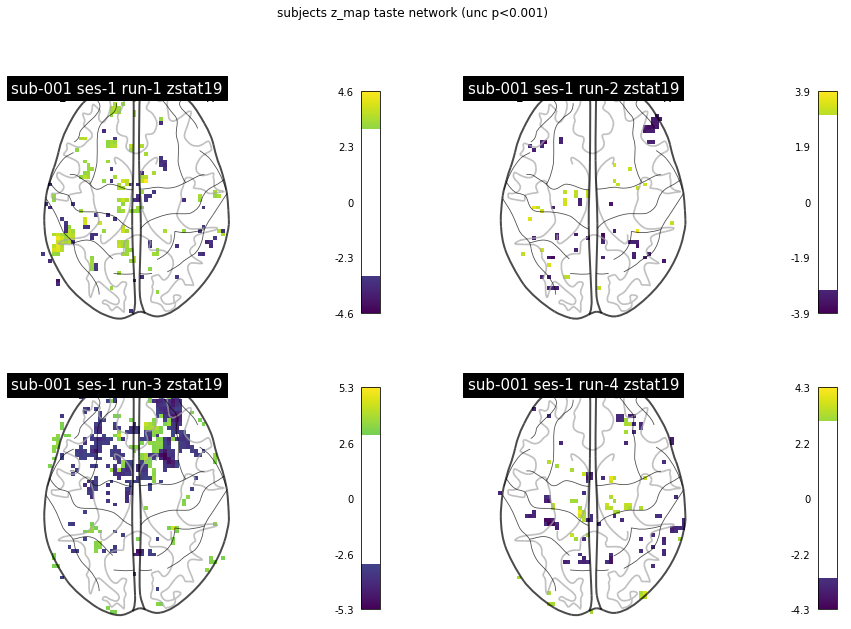

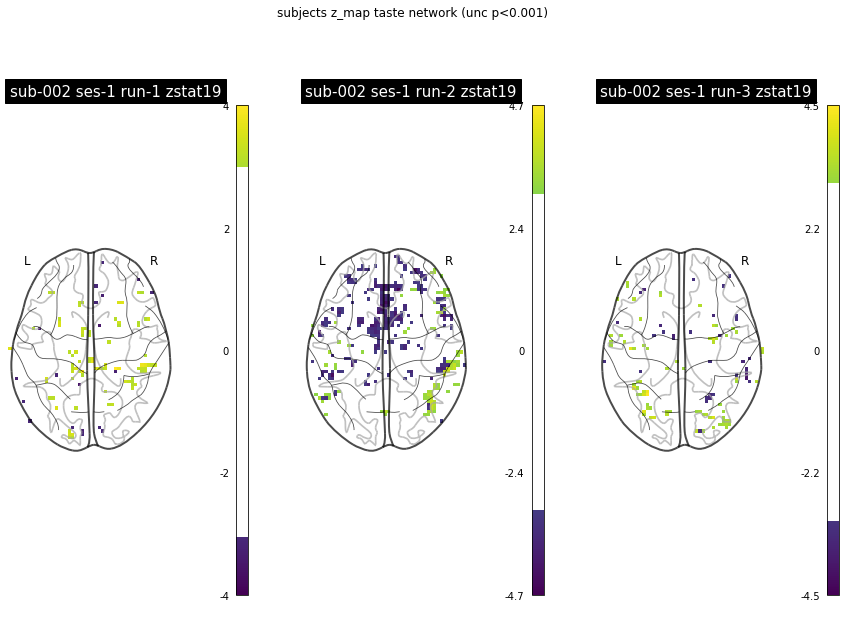

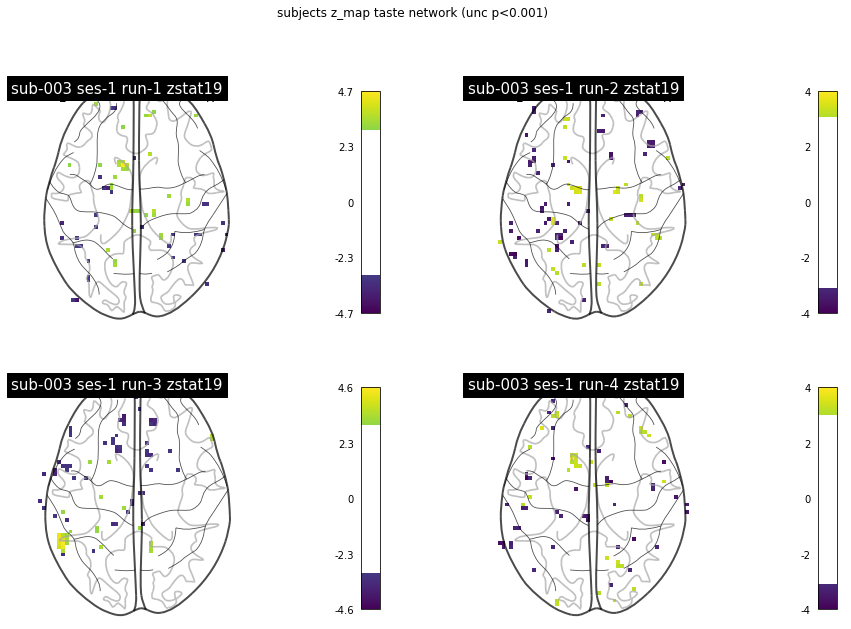

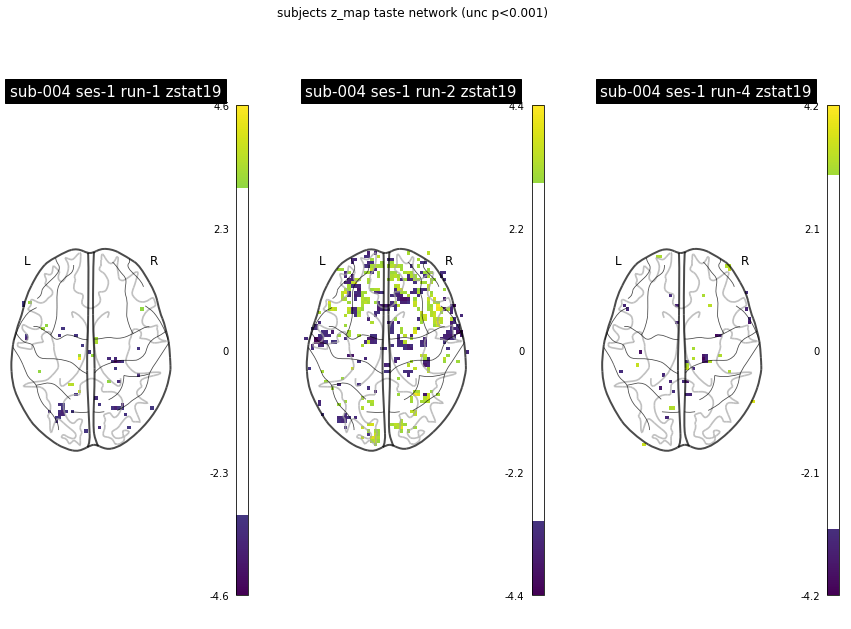

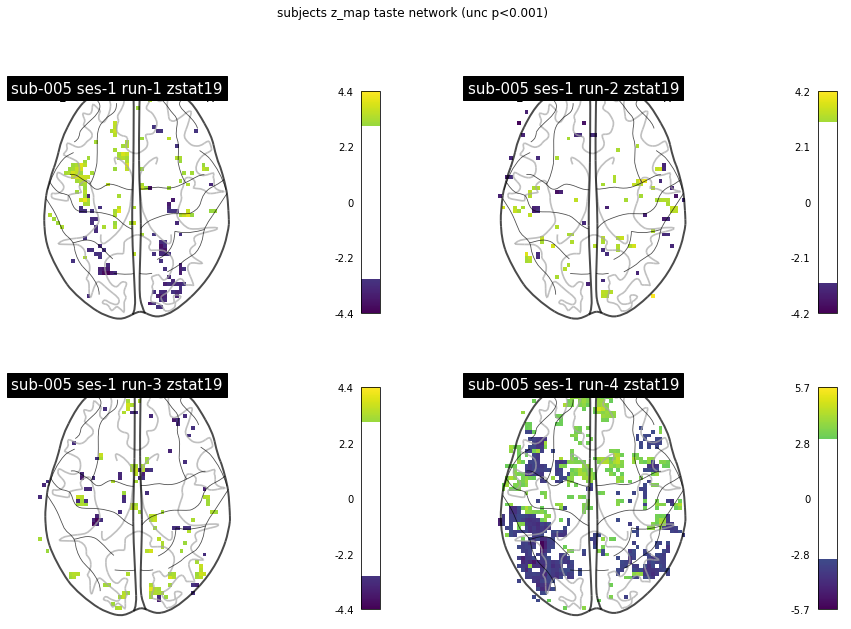

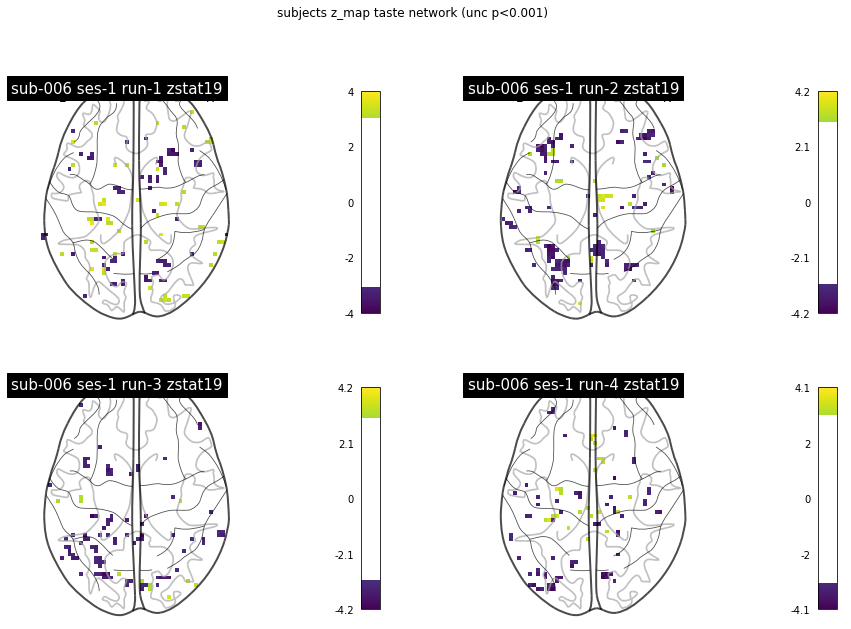

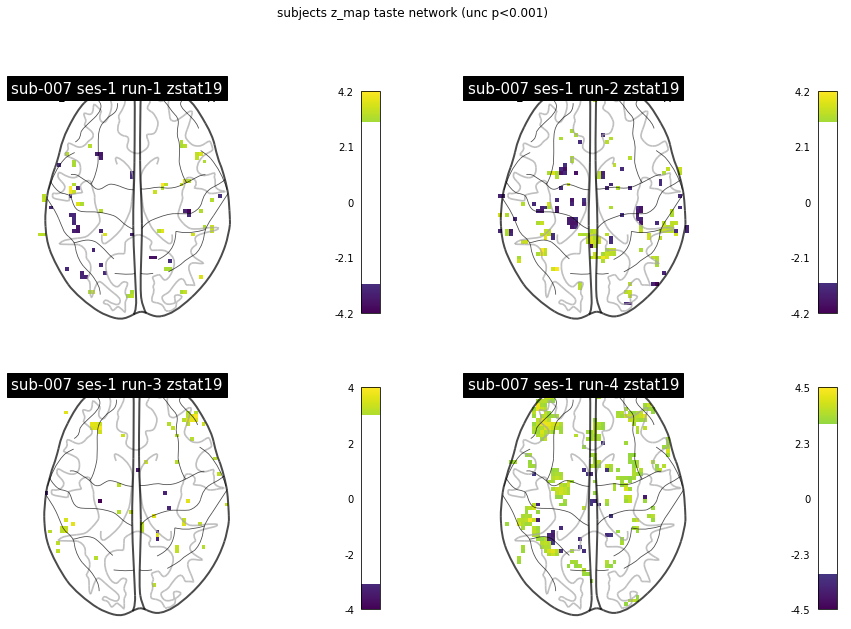

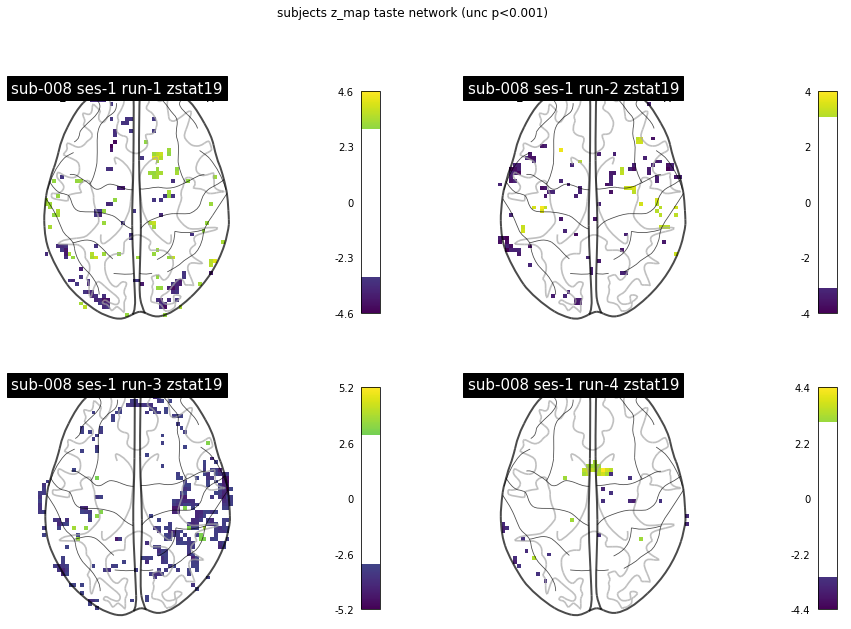

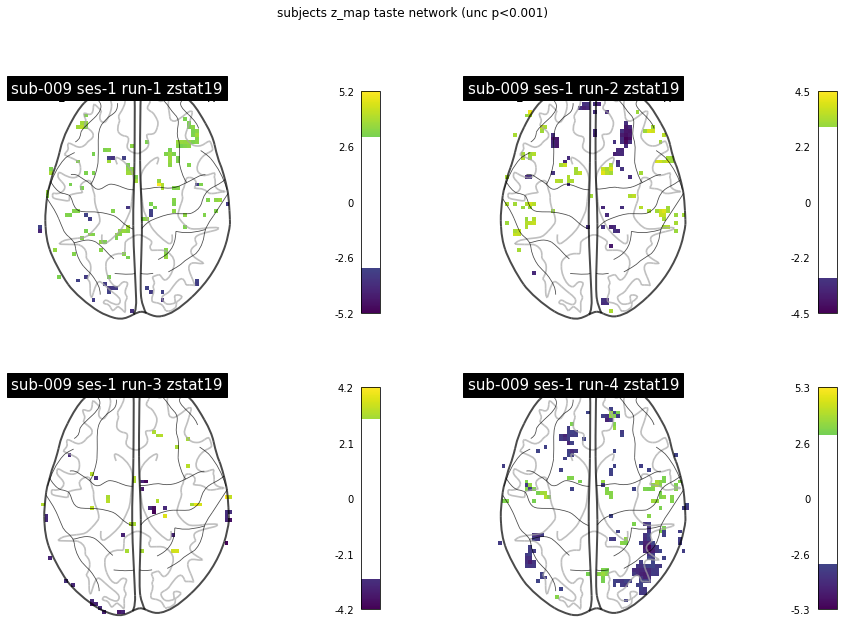

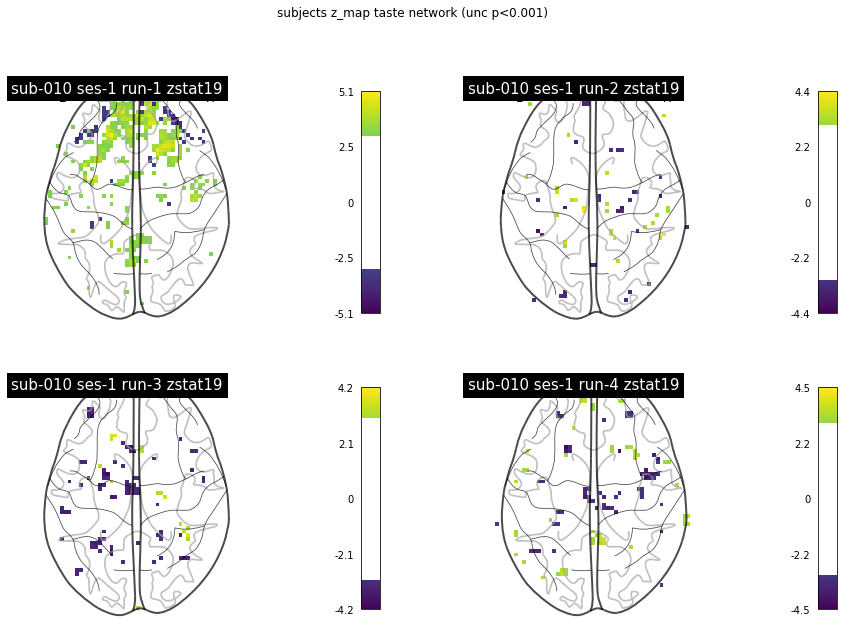

In [158]:
from nilearn import plotting
from scipy.stats import norm
for sub_id in sub_ids[:10]:
    #sub_id='sub-044'
    display_fsl_feat1('zstat19',sub_id,  'ses-1','19contrasts')

    


---

### Write Files

In [61]:
from pandas import ExcelWriter

In [62]:
pathT='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-feat1_report.xlsx'

with pd.ExcelWriter(pathT, engine='xlsxwriter') as writer:    
    s1_feat1_df.to_excel(writer, 'ses-1_model1')   
    #s2_df_trim.to_excel(writer, 'ses-2_bids')   
    writer.save()  

In [24]:
path='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-trimmed_report.xlsx'


In [25]:
writer = pd.ExcelWriter(path, engine = 'openpyxl')
book = load_workbook(path)
writer.book = book
s1_feat1_df.to_excel(writer, sheet_name="ses-1_feat1")
#s2_df.to_excel(writer, sheet_name="ses-2_fmriprep")
writer.save()
writer.close()

In [26]:
new_excel=pd.read_excel(path, sheet_name="ses-1_feat1")


In [27]:
new_excel.head()

,patID,run-4_cope_file_ct,run-4_cope1_mean,run-4_cope2_mean,run-4_cope3_mean,run-4_cope4_mean,run-4_cope5_mean,run-4_cope6_mean,run-4_cope7_mean,run-4_cope8_mean,...,run-3_cope12_mean,run-3_cope13_mean,run-3_cope14_mean,run-3_cope15_mean,run-3_cope16_mean,run-1_cope17_mean,run-2_cope17_mean,run-4_cope17_mean,run-3_cope17_mean,ses-1_cope_file_ct
0,sub-001,17.0,41.345301,37.011063,6.384902,41.984286,4.334238,-30.626161,34.960399,-4.353627,...,-2.695001,2.399049,-3.936486,-5.094049,-6.335534,-4.940643,-1.315183,-0.638985,1.241485,17
1,sub-002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,sub-003,17.0,18.472461,19.519152,-17.503614,14.059235,-1.046690,-37.022765,35.976075,-4.462705,...,-0.185602,-1.068138,-1.805646,0.882537,-0.737508,0.337266,5.575037,4.413227,1.620045,17
3,sub-004,17.0,16.965965,33.591780,6.834999,17.913703,-16.625816,-26.756781,10.130965,-2.948859,...,NaN,NaN,NaN,NaN,NaN,3.094433,1.091694,-0.947739,NaN,17
4,sub-005,17.0,28.673747,-18.495300,16.471535,23.579708,47.169047,34.966836,12.202211,5.257966,...,1.963568,-0.502583,-4.664245,2.466151,-4.161662,3.151686,3.367997,5.094038,6.627813,17


In [154]:
plt.rcParams["figure.figsize"] = (50,35)


[INFO] design (.png) file taken from file: 
 /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2_19contrasts.feat/design.png


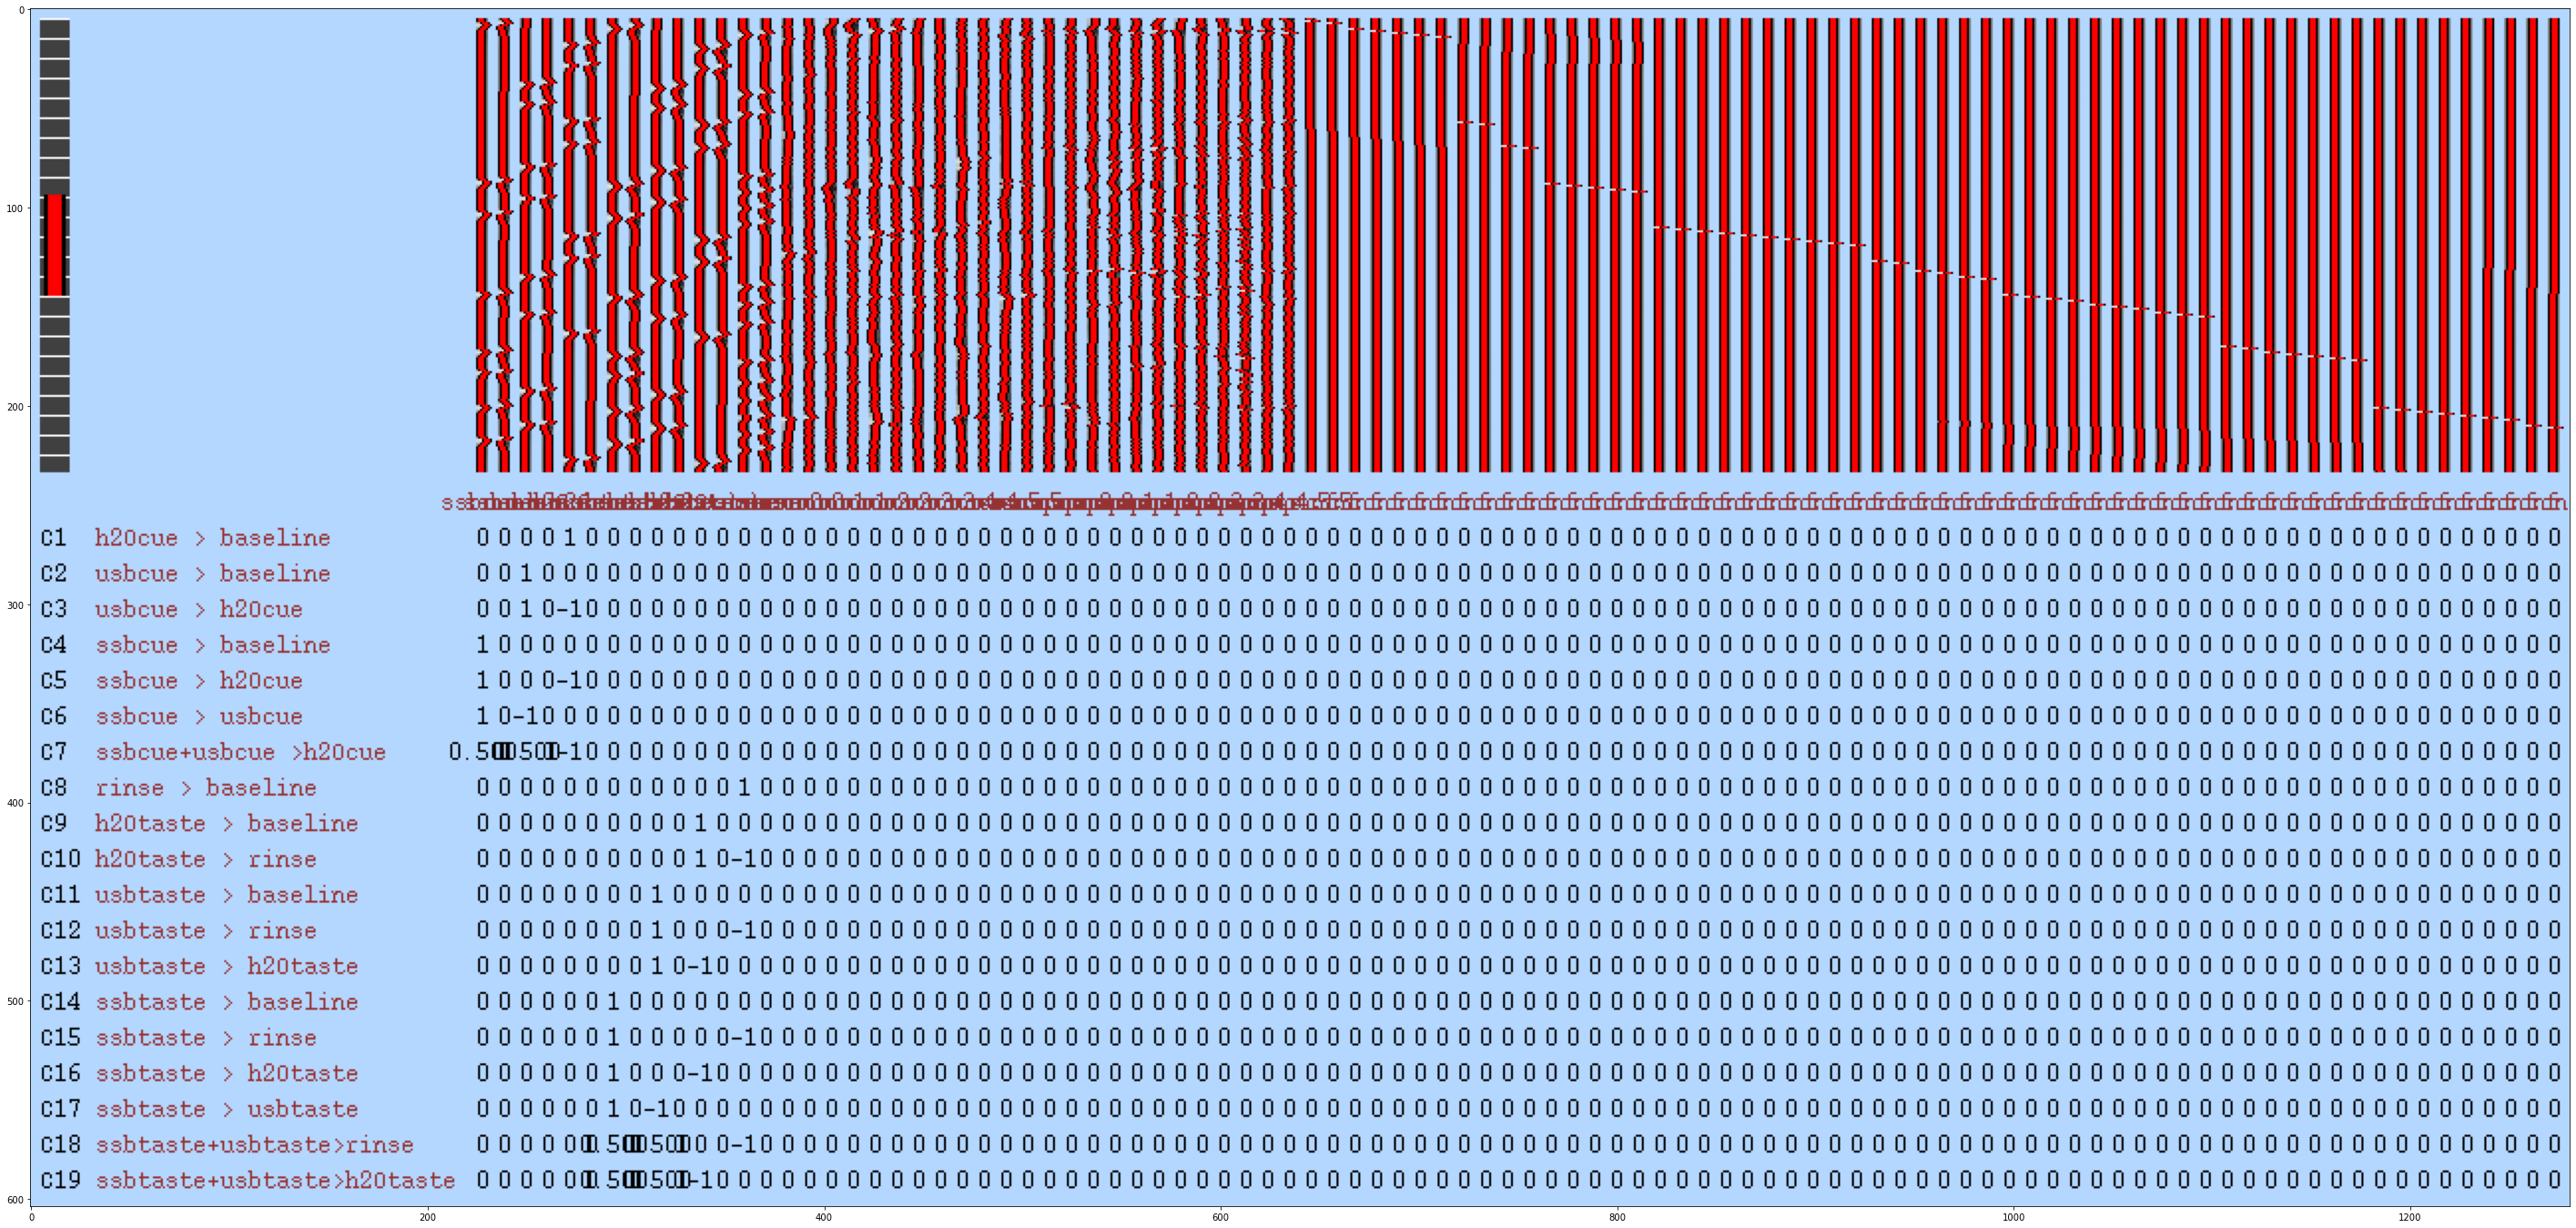

In [155]:
# displaym random design file sample

design_sample='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2_19contrasts.feat/design.png'

print('[INFO] design (.png) file taken from file: \n', 
      design_sample)


img = mpimg.imread(design_sample)
imgplot = plt.imshow(img)
plt.show()



---